In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import re
import math
import random

#0-1 normalisation
from sklearn import preprocessing
#modelling
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import cleaning_processing, HenDailyVariable_Origins, plot_scikit_lda, explained_var, plot_cov_ellipse
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
random.seed(0)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#initialise parameters
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
pal_ = config.pal_
dico_matching = config.dico_matching
dico_night_hour = config.dico_night_hour
dico_garden_opening_hour = config.dico_garden_opening_hour
path_extracted_data_cleaning = os.path.join(path_extracted_data,'Cleaning')
path_extracted_data_cleaning_rawvscleaned = os.path.join(path_extracted_data_cleaning,'Raw&Cleaned')  
path_extracted_data_cleaning_rawvscleaned_LDA = os.path.join(path_extracted_data_cleaning_rawvscleaned,'LDA')
if not os.path.exists(path_extracted_data_cleaning_rawvscleaned_LDA):
    os.makedirs(path_extracted_data_cleaning_rawvscleaned_LDA)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download data

In [6]:
#for being more reproductible, we open the file that was saved from cleaning
df_var = pd.read_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned, 'daily_ALL_variables.csv'), sep=';', 
                 parse_dates=['level'], dayfirst=True) 
print(df_var.shape)
df_var.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(27888, 118)


HenID      level  duration_1_Zone  duration_2_Zone  duration_3_Zone  \
0  hen_131 2020-10-27           2258.0          19888.0          16978.0   
1  hen_131 2020-10-28           3643.0          19470.0          17180.0   
2  hen_131 2020-10-29           2642.0          21300.0          19136.0   

   duration_4_Zone  duration_5_Zone  verification_daily_total_duration  \
0           3204.0            872.0                            43200.0   
1           2504.0            403.0                            43200.0   
2           2727.0            995.0                            46800.0   

                                  dur_values  \
0  [2258.0, 19888.0, 16978.0, 3204.0, 872.0]   
1  [3643.0, 19470.0, 17180.0, 2504.0, 403.0]   
2  [2642.0, 21300.0, 19136.0, 2727.0, 995.0]   

                               dur_values_normalized  ...  \
0  [0.05226851851851852, 0.4603703703703704, 0.39...  ...   
1  [0.0843287037037037, 0.45069444444444445, 0.39...  ...   
2  [0.05645299145299145, 0.4551282051282051, 0.40...  ...   

  nbr_temperature_nnnan temperature_night20_2_median  \
0                  36.0                         29.0   
1                  36.0                         29.0   
2                  36.0                         29.0   

  temperature_night20_2_max temperature_night20_2_var  \
0                      30.0                  0.212191   
1                      29.0                  0.212191   
2                      29.0                  0.076389   

                         list_of_MovementCounter_day  len_MovementCounter_day  \
0  [41.0, 62.0, 72.0, 71.0, 63.0, 50.0, 36.0, 39....                     72.0   
1  [45.0, 78.0, 59.0, 64.0, 52.0, 43.0, 43.0, 55....                     72.0   
2  [18.0, 30.0, 30.0, 65.0, 48.0, 44.0, 66.0, 61....                     78.0   

  MovementCounter_day_amount_nnactivity MovementCounter_day_max  \
0                              0.000000                   103.0   
1                              0.000000                   109.0   
2                              0.012821                   108.0   

  MovementCounter_day_mean      type  
0                67.236111  cleaning  
1                69.138889  cleaning  
2                69.333333  cleaning  

[3 rows x 118 columns]

In [83]:
#we separate here, so that we can reuse for the final dataset
type_ = 'cleaning'
#type_ = 'raw'

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [84]:
#keep hens that have more than X days
li_lda = ['duration_2_Zone','duration_3_Zone','duration_5_Zone','median_duration','variance_duration','distribution_entropy',
          'sucessIntrusion_9','Max_duration_WG', 'in_WG_15mnAfterOpening',
          'night_Total_number_transition','vertical_travel_distance']
li_lda = ['nbr_stays_2_Zone','nbr_stays_3_Zone','nbr_stays_5_Zone','nbr_stays_1_Zone','median_duration','variance_duration','distribution_entropy',
          'sucessIntrusion_9','Max_duration_WG', 'in_WG_15mnAfterOpening',
          'night_Total_number_transition','vertical_travel_distance']
df = df_var[df_var['type']==type_][li_lda+['HenID']].copy()
print(df.shape)
df = df[~df.isnull().any(axis=1)]
print(df.shape)
#select hens
df_ = df.groupby(['HenID'])['in_WG_15mnAfterOpening'].count().reset_index()
df_['has_more_Xdays'] = df_['in_WG_15mnAfterOpening'].map(lambda x: x>70)
display(df_.head(3))
li_hen2keep = df_[df_['has_more_Xdays']]['HenID'].unique()
df['in_WG_15mnAfterOpening'] = df['in_WG_15mnAfterOpening'].map(lambda x: int(x))
df = df[df['HenID'].isin(li_hen2keep)].copy()
print(df.shape)
df.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(13944, 13)
(12632, 13)


HenID  in_WG_15mnAfterOpening  has_more_Xdays
0    hen_1                      79            True
1   hen_10                      79            True
2  hen_100                      21           False

(11228, 13)


nbr_stays_2_Zone  nbr_stays_3_Zone  nbr_stays_5_Zone  nbr_stays_1_Zone  \
0              24.0              25.0               1.0               8.0   
1              25.0              19.0               1.0               9.0   
2              25.0              29.0               2.0               8.0   

   median_duration  variance_duration  distribution_entropy  \
0            405.0      435547.517042              1.150143   
1            674.0      390521.177170              1.143123   
2            391.0      475578.502277              1.133719   

   sucessIntrusion_9  Max_duration_WG  in_WG_15mnAfterOpening  \
0           0.333333            577.0                       0   
1           0.500000           1247.0                       1   
2           0.200000           1061.0                       0   

   night_Total_number_transition  vertical_travel_distance    HenID  
0                            2.0                      50.0  hen_131  
1                            4.0                      39.0  hen_131  
2                            0.0                      61.0  hen_131

In [85]:
#normalize
#scaling numerical data: necessary due to duration high values
sc = StandardScaler()
df[li_lda] = sc.fit_transform(df[li_lda])
df[li_lda].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


nbr_stays_2_Zone  nbr_stays_3_Zone  nbr_stays_5_Zone  nbr_stays_1_Zone  \
0          0.328146          0.243602         -1.158257          1.618735   
1          0.413442         -0.266516         -1.158257          1.919081   
2          0.413442          0.583681         -0.891178          1.618735   

   median_duration  variance_duration  distribution_entropy  \
0        -0.124813          -0.251662              0.320189   
1        -0.064165          -0.252831              0.293226   
2        -0.127969          -0.250622              0.257105   

   sucessIntrusion_9  Max_duration_WG  in_WG_15mnAfterOpening  \
0          -0.208596         0.080763               -0.404827   
1           0.344795         0.645395                2.470189   
2          -0.651309         0.488647               -0.404827   

   night_Total_number_transition  vertical_travel_distance  
0                       0.027525                 -0.255567  
1                       0.326853                 -0.681769  
2                      -0.271802                  0.170635

In [86]:
X = df[li_lda].values
y = df['HenID'].values
print(X.shape, y.shape)
df[li_lda][df[li_lda].isnull().sum(axis=1)>1]

(11228, 12) (11228,)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Empty DataFrame
Columns: [nbr_stays_2_Zone, nbr_stays_3_Zone, nbr_stays_5_Zone, nbr_stays_1_Zone, median_duration, variance_duration, distribution_entropy, sucessIntrusion_9, Max_duration_WG, in_WG_15mnAfterOpening, night_Total_number_transition, vertical_travel_distance]
Index: []

In [87]:
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(X, y)
#extract the labels
li_labels = lda.classes_
print(li_labels[0:10])
#defined nbr components to analyse
nbr_lda_components = 4

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['hen_1' 'hen_10' 'hen_101' 'hen_102' 'hen_105' 'hen_106' 'hen_107'
 'hen_108' 'hen_109' 'hen_111']


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


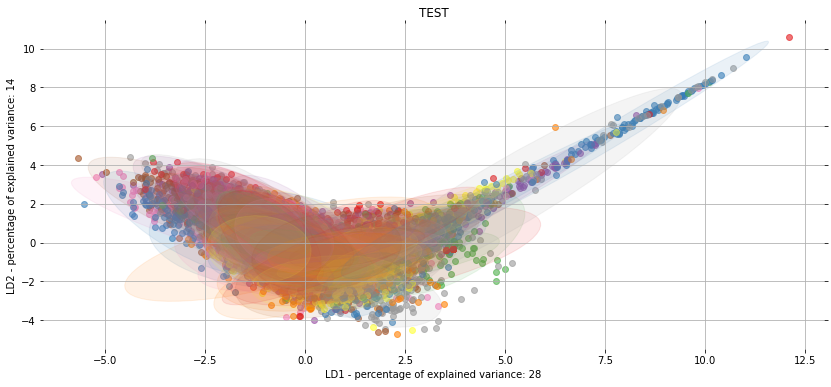

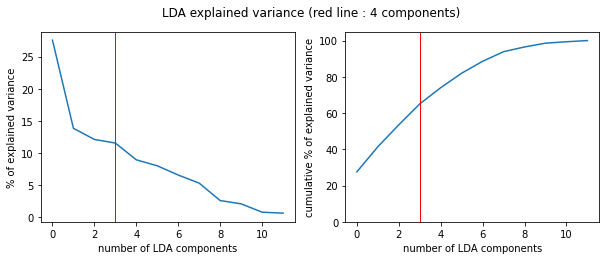

We have 142 hens, 11228 observations (~79 per class), 12 expl. variables 
(142, 12) (142, 12)
(12, 12)
(12,)


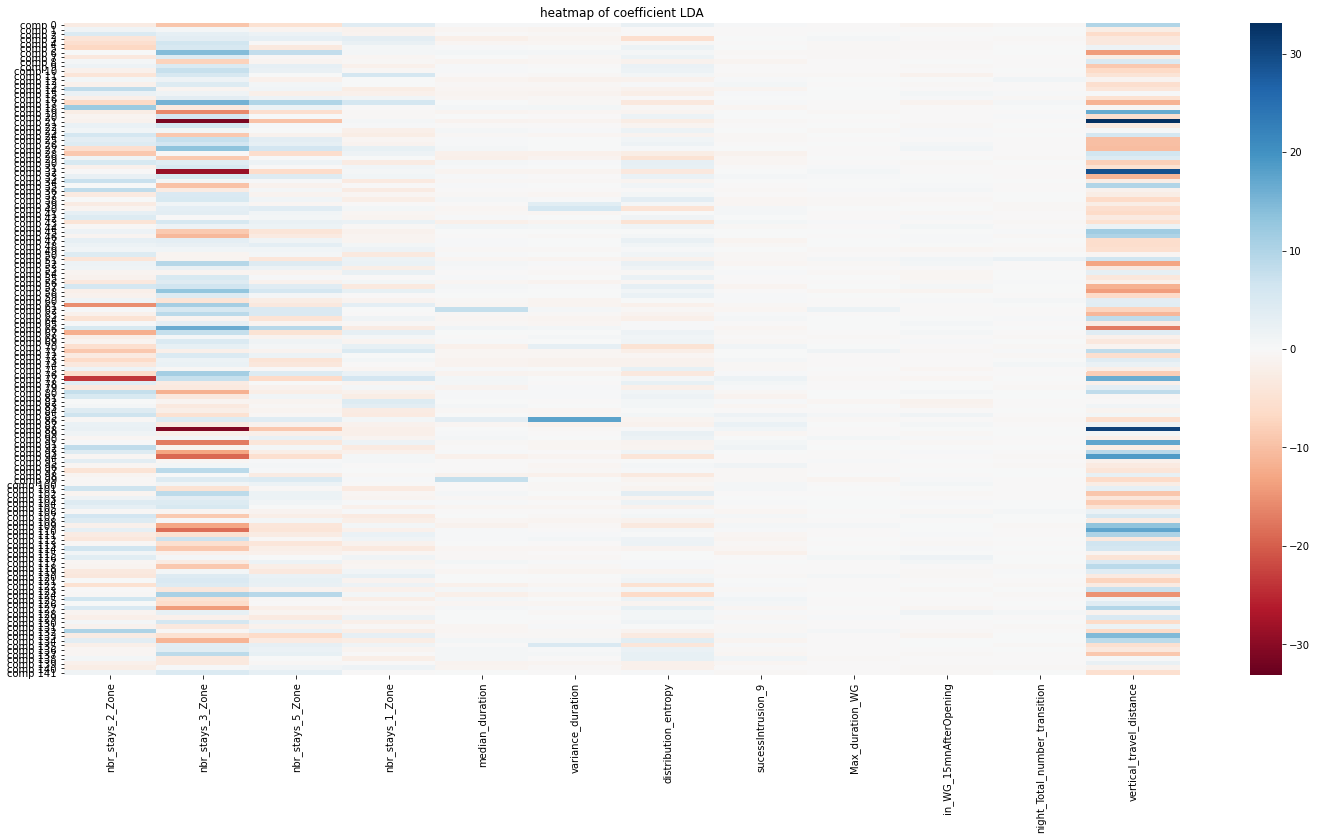

(4, 12)


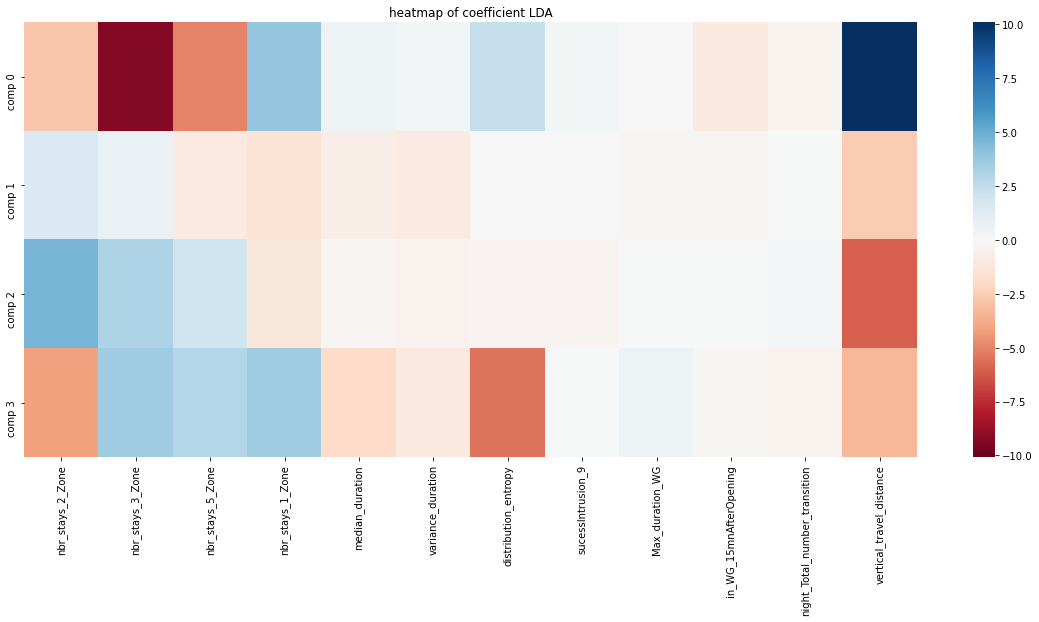

In [88]:
#Hens into the LDA 2Dspace
X_lda_sklearn = lda.transform(X)
#plot with the first two components
plot_scikit_lda(X_lda_sklearn, y, lda, 'TEST', path_extracted_data_cleaning_rawvscleaned_LDA)

#save it
'''dico_h_dinfo = {}
for h in set(y):
    for day_ in range(sum(y==h)):
        name_ = h+'_day_'+str(day_)
        if name_ not in dico_h_dinfo:
            dico_h_dinfo[name_] = {'HenID':h,'day':dico_hen_dates[h][day_]}
        for i in range(nbr_lda_components):
            dico_h_dinfo[name_]['ID'+str(i)] = list(X_lda_sklearn[:,i][y==h])[day_]
df_IDS = pd.DataFrame(list(dico_h_dinfo.values()))
#df_IDS['max_severity'] = df_IDS['HenID'].map(lambda x: dico_h_ms[x])
print(df_IDS.shape, df.shape)
df_IDS = pd.merge(df_IDS, df.filter(li_output+['HenID','day']),on=['HenID','day'],how='inner')
#df_IDS.to_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned_LDA,'df_IDS_onall.csv'), index=False, sep=';')
print(df_IDS.shape)
display(df_IDS.head(3))'''

#LDA comp explained variance
explained_var(lda, nbr_lda_components, path_extracted_data_cleaning_rawvscleaned_LDA)

#LDA component & Expl. var
#small info on input/ouput shape
print('We have %d hens, %d observations (~%d per class), %d expl. variables '%(len(set(y)), 
                                                                               X.shape[0], X.shape[0]/len(set(y)),
                                                                               X.shape[1]))
#for each hen we have the coefficient/mean linked to each expl. variables
print(lda.coef_.shape, lda.means_.shape)
#for each expl. variables we have a row/column in the cov matrix
print(lda.covariance_.shape)
#for each of the n_components we have the explained_variance_ratio (by default its the min(n_classes - 1, n_features))
print(lda.explained_variance_ratio_.shape)

#for each of the lda components its link to the associated variables (50,54). Lets do a heatmap of the coefficient strength
plt.figure(figsize=(25,12))
M = lda.coef_
v = max(abs(M.min()),M.max())
sns.heatmap(M, xticklabels=li_lda, yticklabels=['comp '+str(i) for i in range(lda.coef_.shape[0])],
            vmin=-v, vmax=v, cmap="RdBu")
plt.title('heatmap of coefficient LDA')
#plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned_LDA, 'heatmap_coefficient_LDA_all_comp.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

#for each of the lda components its link to the associated variables (50,54). Lets do a heatmap of the coefficient strength
plt.figure(figsize=(20,8))
M = lda.coef_
M = M[0:nbr_lda_components,:]
print(M.shape)
v = max(abs(M.min()),M.max())
sns.heatmap(M, xticklabels=li_lda, yticklabels=['comp '+str(i) for i in range(M.shape[0])], vmin=-v, vmax=v, cmap="RdBu")
plt.title('heatmap of coefficient LDA')
#plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned_LDA, 'heatmap_coefficient_LDA_first_comp.png'),dpi=300,format='png', bbox_inches='tight')
plt.show()